# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [24]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil



### Sample Size Calculation

In [37]:
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.06, 0.09) 

In [38]:
# Calculate sample size needed

require_n = sms.NormalIndPower().solve_power(
              effect_size,
              power = 0.8,
              alpha = 0.05,
              ratio = 1 )

require_n = ceil(require_n)
require_n

1199

### Collecting and preparing the data

In [39]:
# Load the tiktok_data.csv into a dataframe

df = pd.read_csv('tiktok_data.csv')

df.head()

,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [40]:
# Get the info of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
user_id      275781 non-null int64
timestamp    275781 non-null object
group        275781 non-null object
button       275781 non-null object
liked        275781 non-null int64
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [41]:
# Make sure all the control group are seeing the star button and viceversa

pd.crosstab(df['group'], df['button'])



button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [42]:
# Check that no users have been sampled multiple times 

session_counts = df['user_id'].value_counts(ascending=False)

muti_users = session_counts[session_counts > 1].count()

muti_users


3453

In [43]:
# If there are users who have been sampled multiple times, remove them from the dataframe

drop_users = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(drop_users)]

df.shape[0]



268875

#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [45]:
# Perform simple random sampling to split the data into control and treatment

control_sample = df[df['group'] == 'control'].sample(n=require_n, random_state = 22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=require_n, random_state = 22)



In [49]:
# Create one table called ab_test that has both the cleaned control and treatment data

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)

ab_test.reset_index(drop=True, inplace = True)

ab_test

,user_id,timestamp,group,button,liked
0,644761,2017-01-20 5:19:16,control,heart,0
1,856804,2017-01-02 23:19:00,control,heart,0
2,728826,2017-01-03 4:16:37,control,heart,0
3,865441,2017-01-19 3:59:57,control,heart,0
4,796969,2017-01-05 4:08:26,control,heart,0
...,...,...,...,...,...
2393,647852,2017-01-16 4:47:04,treatment,star,0
2394,814529,2017-01-15 1:01:37,treatment,star,1
2395,924465,2017-01-13 8:37:42,treatment,star,0
2396,660778,2017-01-12 1:55:29,treatment,star,0


In [50]:
# Count the test groups to make sure that they're balanced 

ab_test['group'].value_counts()

control      1199
treatment    1199
Name: group, dtype: int64

### Analysis Visualization

In [55]:
# Find the like rate by group

liked_rates = ab_test.groupby('group')['liked']


# Find the Std. deviation of the proportion
std_p = lambda x: np.std(x, ddof = 0)

# Find the Std. error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x, ddof = 0)


# Calculate the final like rate
liked_rates = liked_rates.agg([np.mean, std_p, se_p])
liked_rates.columns = ['liked_rate', 'std_deviation', 'std_error']
liked_rates.style.format('{:.3f}')



,liked_rate,std_deviation,std_error
group,,,
control,0.109,0.312,0.009
treatment,0.118,0.323,0.009


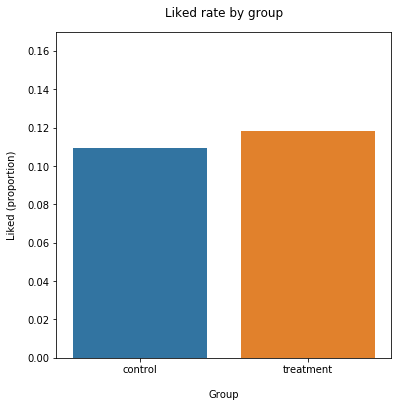

In [60]:
# Plot the like rate by group on a bar plot

plt.figure(figsize = (6, 6))

sns.barplot(x = ab_test['group'], y = ab_test['liked'], ci = False)

plt.ylim(0, 0.17)
plt.title('Liked rate by group', pad=15)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Liked (proportion)', labelpad=10);

### Testing for Stat Sig

In [61]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups
control_results = ab_test[ab_test['group'] =='control']['liked']
treatment_results = ab_test[ab_test['group']== 'treatment']['liked']

# Get the number of samples in both groups
n_con = control_results.count()
n_treat = treatment_results.count()

# Sum up the number of successes (likes) in both groups
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]



In [62]:
# Find the z statistic and p value for proportions based on normal ztest
z_stat, pval = proportions_ztest(successes, nobs = nobs)

# Find the confidence intervals for each test group
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes,
                                                                       nobs = nobs,
                                                                       alpha = 0.5
                                                                       )


In [63]:
# print z statistic
# print p-value
# print ci 95% for control group
# print ci 95% for treatment group

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z statistic: -0.71
p-value: 0.479
ci 95% for control group: [0.103, 0.115]
ci 95% for treatment group: [0.112, 0.125]


### Were the results signficant? 

In [64]:
liked_rates.style.format('{:.3f}')

,liked_rate,std_deviation,std_error
group,,,
control,0.109,0.312,0.009
treatment,0.118,0.323,0.009


### What would you advise the engineering team to do moving forward?